In [1]:
#!pip install bert-pytorch
!pip install sentencepiece
!pip install transformers
!pip install onnx
!pip install fasttext
!pip install torchtext
!pip install scikit-learn
!pip install d2l==1.0.0-alpha1.post0
!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 68.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 1.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 69.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into 

In [17]:
import yaml
import argparse
import time
import copy

import torch
import torchtext
from torchtext import datasets
from torch import nn
from d2l import torch as d2l

import re
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report

In [19]:
import pandas as pd

train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

def change_label(x):
  torch.manual_seed(123)

  if x == "Entailment":
    return 0
  elif x == "Contradiction":
    return 1
  else:
    return 2

train = train.rename(columns={"choice": "label"})
test = test.rename(columns={"choice": "label"})

train["label"] = train.label.apply(lambda x: change_label(x))
test["label"]  = test.label.apply(lambda x: change_label(x))

## Create Dataset

In [20]:
class SNLIDataset(torch.utils.data.Dataset):
    """A customized dataset to load the SNLI dataset."""
    def __init__(self, dataset, num_steps, vocab=None):
        torch.manual_seed(123)
        self.num_steps = num_steps
        all_premise_tokens = d2l.tokenize(dataset["hypotheis"])
        all_hypothesis_tokens = d2l.tokenize(dataset["premise"])
        if vocab is None:
            self.vocab = d2l.Vocab(all_premise_tokens + all_hypothesis_tokens,
                                   min_freq=5, reserved_tokens=['<pad>'])
        else:
            self.vocab = vocab
        self.premises = self._pad(all_premise_tokens)
        self.hypotheses = self._pad(all_hypothesis_tokens)
        self.labels = torch.tensor(dataset["label"])
        print('read ' + str(len(self.premises)) + ' examples')

    def _pad(self, lines):
        torch.manual_seed(123)
        return torch.tensor([d2l.truncate_pad(
            self.vocab[line], self.num_steps, self.vocab['<pad>'])
                         for line in lines])

    def __getitem__(self, idx):
        torch.manual_seed(123)
        return (self.premises[idx], self.hypotheses[idx]), self.labels[idx]

    def __len__(self):
        torch.manual_seed(123)
        return len(self.premises)

In [21]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l



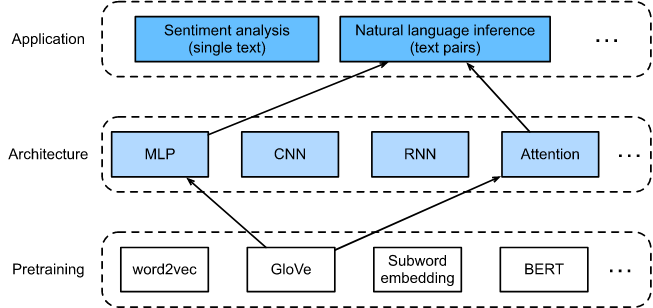

## Model

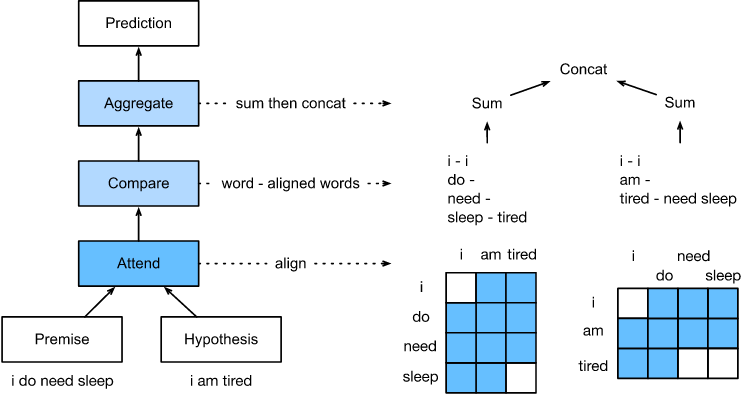

## Atending

In [22]:
def mlp(num_inputs, num_hiddens, flatten):
    torch.manual_seed(123)
    net = []
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_inputs, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_hiddens, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    return nn.Sequential(*net)

In [23]:
class Attend(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        torch.manual_seed(123)
        super(Attend, self).__init__(**kwargs)
        self.f = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B):
        torch.manual_seed(123)
        # Shape of `A`/`B`: (`batch_size`, no. of tokens in sequence A/B,
        # `embed_size`)
        # Shape of `f_A`/`f_B`: (`batch_size`, no. of tokens in sequence A/B,
        # `num_hiddens`)
        f_A = self.f(A)
        f_B = self.f(B)
        # Shape of `e`: (`batch_size`, no. of tokens in sequence A,
        # no. of tokens in sequence B)
        e = torch.bmm(f_A, f_B.permute(0, 2, 1))
        # Shape of `beta`: (`batch_size`, no. of tokens in sequence A,
        # `embed_size`), where sequence B is softly aligned with each token
        # (axis 1 of `beta`) in sequence A
        beta = torch.bmm(F.softmax(e, dim=-1), B)
        # Shape of `alpha`: (`batch_size`, no. of tokens in sequence B,
        # `embed_size`), where sequence A is softly aligned with each token
        # (axis 1 of `alpha`) in sequence B
        alpha = torch.bmm(F.softmax(e.permute(0, 2, 1), dim=-1), A)
        return beta, alpha

## Comparing

In [24]:
class Compare(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        torch.manual_seed(123)
        super(Compare, self).__init__(**kwargs)
        self.g = mlp(num_inputs, num_hiddens, flatten=False)

    def forward(self, A, B, beta, alpha):
        torch.manual_seed(123)
        V_A = self.g(torch.cat([A, beta], dim=2))
        V_B = self.g(torch.cat([B, alpha], dim=2))
        return V_A, V_B

## Aggregating

In [25]:
class Aggregate(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_outputs, **kwargs):
        torch.manual_seed(123)
        super(Aggregate, self).__init__(**kwargs)
        self.h = mlp(num_inputs, num_hiddens, flatten=True)
        self.linear = nn.Linear(num_hiddens, num_outputs)

    def forward(self, V_A, V_B):
        torch.manual_seed(123)
        # Sum up both sets of comparison vectors
        V_A = V_A.sum(dim=1)
        V_B = V_B.sum(dim=1)
        # Feed the concatenation of both summarization results into an MLP
        Y_hat = self.linear(self.h(torch.cat([V_A, V_B], dim=1)))
        return Y_hat

In [26]:
class DecomposableAttention(nn.Module):
    def __init__(self, vocab, embed_size, num_hiddens, num_inputs_attend=100,
                 num_inputs_compare=200, num_inputs_agg=400, **kwargs):
        torch.manual_seed(123)
        super(DecomposableAttention, self).__init__(**kwargs)
        self.embedding = nn.Embedding(len(vocab), embed_size)
        self.attend = Attend(num_inputs_attend, num_hiddens)
        self.compare = Compare(num_inputs_compare, num_hiddens)
        # There are 3 possible outputs: entailment, contradiction, and neutral
        self.aggregate = Aggregate(num_inputs_agg, num_hiddens, num_outputs=3)

    def forward(self, X):
        torch.manual_seed(123)
        premises, hypotheses = X
        A = self.embedding(premises)
        B = self.embedding(hypotheses)
        beta, alpha = self.attend(A, B)
        V_A, V_B = self.compare(A, B, beta, alpha)
        Y_hat = self.aggregate(V_A, V_B)
        return Y_hat

## Focal Loss

In [27]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np

def reweight(cls_num_list, beta=0.9999):
    torch.manual_seed(123)

    """
    Implement reweighting by effective numbers
    :param cls_num_list: a list containing # of samples of each class
    :param beta: hyper-parameter for reweighting, see paper for more details
    :return:
    """
    per_cls_weights = None
    #############################################################################
    # TODO: reweight each class by effective numbers                            #
    #############################################################################
    per_cls_weights = []
    for cls_num in cls_num_list:
        per_cls_weights.append((1 - beta) / (1 - (beta ** cls_num)))         
    #############################################################################
    #                              END OF YOUR CODE                             #
    #############################################################################
    return per_cls_weights


class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=0.1, device='cpu'):
        torch.manual_seed(123)
        super(FocalLoss, self).__init__()
        assert gamma >= 0
        self.gamma = gamma
        self.weight = weight
        self.device = device

    def forward(self, input, target):
        """
        Implement forward of focal loss
        :param input: input predictions
        :param target: labels
        :return: tensor of focal loss in scalar
        """
        torch.manual_seed(123)
        loss = None
        #############################################################################
        # TODO: Implement forward pass of the focal loss                            #
        #############################################################################
        
        input = input.to(self.device)
        target = target.to(self.device)
        import torch.nn.functional as F
        weight=torch.from_numpy(np.array(self.weight)).float().to(self.device)
        ce_loss = F.cross_entropy(input, target,  weight=weight)
        pt = torch.exp(-ce_loss) 
        foc_loss = ((1 -pt) ** self.gamma * ce_loss)
        loss = foc_loss.mean()
        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################
        return loss

# Hyperparameters


In [28]:
torch.manual_seed(123)


def load_config_notebook():
  class Args:
    num_step = 50
    batch_size= 256
    learning_rate= 0.01
    reg= 0.0001
    epochs= 10
    steps= [6, 8]
    warmup= 0
    momentum= 0.75
    gamma=3
    beta= .75
    max_netural= 5
    save_best= True
    model= DecomposableAttention
    trainer= "Adam" #SGD can be Adam or SGD
    loss= "Focal" #CrossEntropyLoss can be Focal or CrossEntropyLoss

  return Args()

args = load_config_notebook()

## Training Model

In [29]:
train["label"] = train["label"].astype(int)
test["label"] = test["label"].astype(int)

loss 0.000, train acc 0.890, test acc 0.892
16230.1 examples/sec on [device(type='cuda', index=0)]


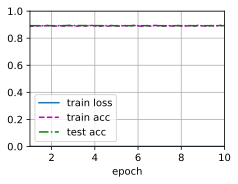

In [30]:
#############################################################
# Create Dataset
#############################################################
torch.manual_seed(123)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_steps = args.num_step
batch_size = args.batch_size
num_workers = d2l.get_dataloader_workers()
train_set = SNLIDataset(train, num_steps)
test_set = SNLIDataset(test, num_steps, train_set.vocab)
vocab = train_set.vocab
train_iter = torch.utils.data.DataLoader(train_set, batch_size,
                                             shuffle=False,
                                             num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                        shuffle=False,
                                        num_workers=num_workers)
#############################################################
# Set Up Model and Glove components
#############################################################
embed_size, num_hiddens, devices = 100, 200, d2l.try_all_gpus()
net = DecomposableAttention(vocab, embed_size, num_hiddens)
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds);

#############################################################
# Train Model
#############################################################

torch.manual_seed(123)

#reweight labels
a = train.label.value_counts()
cls_num_list = list([a[0],a[1],a[2]])
per_cls_weights =  reweight(cls_num_list, beta=args.beta)

#hyperparam criterion
if args.trainer == "Adam":
  trainer = torch.optim.Adam(net.parameters(), lr=args.learning_rate)
else:
  trainer = torch.optim.SGD(net.parameters(), lr=args.learning_rate,\
                            momentum=args.momentum)
#hyperparam loss function
if args.loss == "Focal":
  loss = FocalLoss(weight=per_cls_weights, gamma=args.gamma).to(device)
else:
  loss = nn.CrossEntropyLoss(reduction="none")

d2l.train_ch13(net, train_iter, test_iter, loss, trainer, args.epochs, devices)

In [31]:
train.label.value_counts()

2    67778
0     6761
1     1578
Name: label, dtype: int64

## Testing and Prediction

In [32]:
def predict_snli(net, vocab, premise, hypothesis):
    torch.manual_seed(123)
    """Predict the logical relationship between the premise and hypothesis."""
    net.eval()
    premise = torch.tensor(vocab[premise], device=d2l.try_gpu())
    hypothesis = torch.tensor(vocab[hypothesis], device=d2l.try_gpu())
    label = torch.argmax(net([premise.reshape((1, -1)),
                           hypothesis.reshape((1, -1))]), dim=1)
    return 'Entailment' if label == 0 else 'Contradiction' if label == 1 \
            else 'neutral'

In [33]:
predict_snli(net, vocab, train.iloc[4, :]["premise"].split(), \
             train.iloc[4, :]["hypotheis"].split())

'neutral'

In [40]:
y_hat=[]
for i in range(len(test)):
    y_hat.append(predict_snli(net, vocab, test.iloc[i, :]["premise"].split(), \
                          test.iloc[i, :]["hypotheis"].split()))
    
    

In [43]:
import collections

frequency = collections.Counter(y_hat)
frequency

Counter({'neutral': 22273})

In [44]:
y_hat_transformed = [change_label(x) for x in y_hat]

## Metrics

In [45]:
labels = test["label"].values

In [46]:
print(f"\n {classification_report(labels, y_hat_transformed, labels=[0,1,2])}")


               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1977
           1       0.00      0.00      0.00       422
           2       0.89      1.00      0.94     19874

    accuracy                           0.89     22273
   macro avg       0.30      0.33      0.31     22273
weighted avg       0.80      0.89      0.84     22273



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
